In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax_kernels as ker 

import jax.numpy as jnp
from jax import jit, vmap
from jax import jacfwd, jacrev
from jax.scipy.stats import multivariate_normal


We aim at minimizing $$\mathcal{F}_P(Q) = \mathcal{L}(Q) + D_{KL}(Q||Q_0)$$ where $Q_0 = \mathcal{N}(0,I_d)$ and $P$ is the minimizer and has a positive density $$p(x) \propto q_0(x) \exp(-\mathcal{L}'(P)(x)).$$
To do this we run the stochastic process, for $k=1,...,T$,
$$X[k+1] = X[k] - \eta \nabla 
V(X[k]) + \sqrt{2 \eta} Z[k]$$
where 
- X[k] is a set of particules at recursion $k$ ($n$ particules in $\mathbb{R}^d$) (shape $(n,d)$)
- $n$ is the number of particules and $d$ the dimension
- $Z[1],...,Z[T]$ are iid gaussian noises (shape $(n,d)$)
- $\nabla V (X[k]) = \nabla_W \mathcal{L}(\hat{Q}[k])(X[k]) - \nabla \log q_0(X[k])$ where $\hat{Q}[k] = \frac1n \sum_{j=1}^n \delta_{X^j[k]}$.



In [2]:
def kl_divergence_kde(X, num_samples=1000):
    n, d = X.shape
    
    # KDE approximation using JAX
    def kde_density(data, points, bandwidth=1.0):
        diff = jnp.expand_dims(points, axis=1) - jnp.expand_dims(data, axis=0)  # (num_samples, n, d)
        dist = jnp.linalg.norm(diff, axis=2)  # (num_samples, n)
        weights = jnp.exp(-dist**2 / (2 * bandwidth**2))  # (num_samples, n)
        density = jnp.sum(weights, axis=1) / (n * (bandwidth * jnp.sqrt(2 * jnp.pi))**d)
        return jnp.log(density)

    # Resample points from KDE
    samples = X[np.random.choice(n, num_samples, replace=True)]  # Resampling from X
    log_qn = kde_density(X, samples)  # Log density of KDE at sampled points

    # Log density of standard Gaussian
    log_q0 = multivariate_normal.logpdf(samples, mean=jnp.zeros(d), cov=jnp.eye(d))

    # KL divergence estimate
    kl_estimate = jnp.mean(log_qn - log_q0)
    return kl_estimate

def q_0(X):
    return jnp.exp(-jnp.linalg.norm(X,axis =1)**2 / 2) / jnp.sqrt(2 * jnp.pi)
def F(L,X):
    n = len(X)
    KL = kl_divergence_kde(X)
    return L(X) + KL

# I/ Gaussian kernel  : $k(x,y) = e^{\frac{-\|x-y\|^2}{2}}$.

# 1. Sanity Check 

- $q_0(x) \propto \exp(-\|x\|^2/2)$
- $\mathcal{L}(Q)(x) = \int v(x) \ d Q(x)$, with $v(x) =  \frac{-\|x\|^2}{4}$


In this case, $\mathcal{L}'(Q)(x) = v(x)$ and $p(x) \propto e^{-\frac{\|x\|^2}{4}}$, so $P = \mathcal{N}(0,2 I_d)$.

<!-- F(q) = L(q) + Kl(q|q0) = L(q) + int -log q0 dq +int log q dq 
L(Q) = int v(x)dq
alors F(q) = int v(x)-log q0 dQ + int log q dq = KL(q|p) où p(x) propto q0 exp(v) = exp(-||x||^2/2 + v)


P(x) propto qO(x) exp(-L'(P)(x)) -->


In [25]:
sigma = 1.0
def k(x,y):
    return jnp.exp(-jnp.dot(x-y,x-y) / (2*sigma**2))

def s_q0(X): 
    return -X
def v(X):
    return -1/4 * np.linalg.norm(X, axis=1)**2 
def L(X):
    return np.mean(v(X))
def _grad_v(X):
    return -X/2 
def grad_L(X):
    return _grad_v(X) 
def gradV(X):
    return grad_L(X) - s_q0(X)

k_PQ = ker.GradientKernel(gradV,k)
KGD = ker.KernelGradientDiscrepancy(k_PQ)



In [52]:
n = 100
d = 2
Eta = np.arange(0.01,2,0.1)
T = 100

KGD_values = np.zeros((len(Eta), T))
F_P_values = np.zeros((len(Eta), T))
all_particles = np.zeros((len(Eta), T, n, d))


for e in range(len(Eta)):
    X = np.random.randn(n, d)+ np.array([-5, 5])
    for k in range(T):
        Z = np.random.randn(n, d)
        X = X - Eta[e] * gradV(X) + np.sqrt(2*Eta[e])* Z
        
        KGD_values[e,k] = KGD.evaluate(X)
        all_particles[e, k] = X
        F_P_values[e,k] = F(L, X)

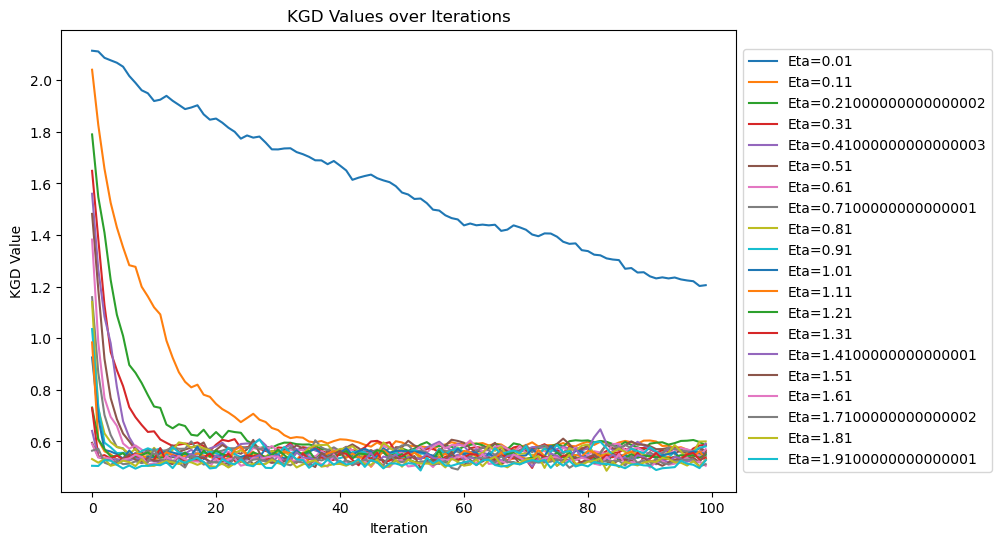

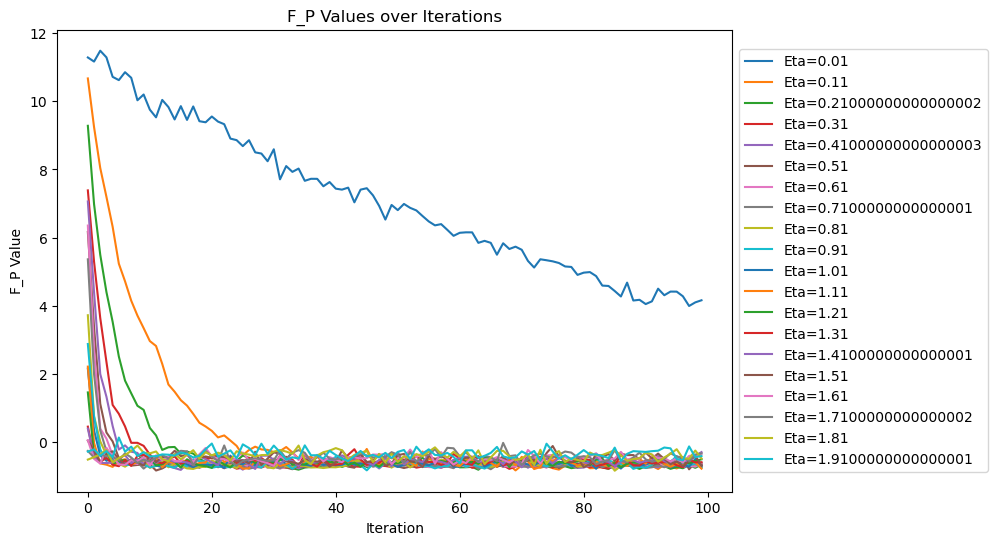

In [58]:
# Plot the value of KGD over iterations
plt.figure(figsize=(10, 6))  # Increase the width of the figure
for e in range(len(Eta)):
    plt.plot(KGD_values[e], label=f'Eta={Eta[e]}')
plt.xlabel('Iteration')
plt.ylabel('KGD Value')
plt.title('KGD Values over Iterations')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend to the right
plt.subplots_adjust(right=0.8)  # Adjust the right margin to make space for the legend
plt.show()

# Plot the value of F_P over iterations
plt.figure(figsize=(10, 6))  # Increase the width of the figure
for e in range(len(Eta)):
    plt.plot(F_P_values[e], label=f'Eta={Eta[e]}')
plt.xlabel('Iteration')
plt.ylabel('F_P Value')
plt.title('F_P Values over Iterations')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend to the right
plt.subplots_adjust(right=0.8)  # Adjust the right margin to make space for the legend
plt.show()


In the following we compare the curves of KGD $(\eta)$ and $\mathcal{F}_P(\eta)$

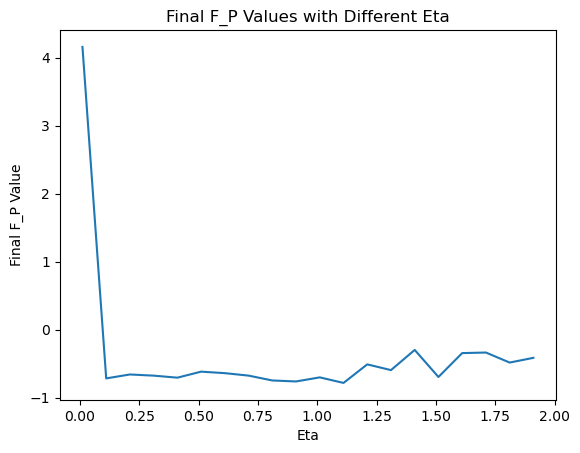

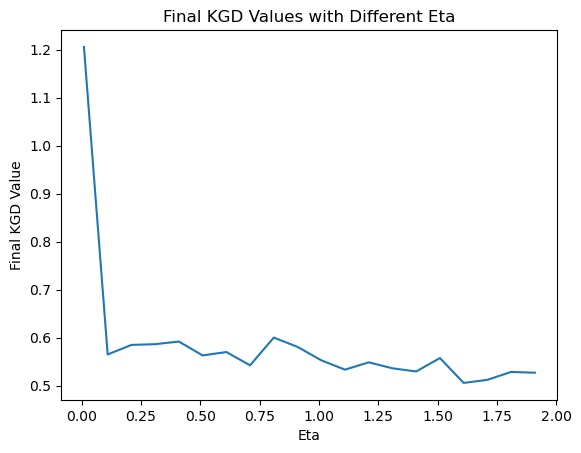

In [59]:
plt.plot(Eta, F_P_values[:, -1])
plt.xlabel('Eta')
plt.ylabel('Final F_P Value')
plt.title('Final F_P Values with Different Eta')
plt.show()

plt.figure()
plt.plot(Eta, KGD_values[:, -1])
plt.xlabel('Eta')
plt.ylabel('Final KGD Value')
plt.title('Final KGD Values with Different Eta')
plt.show()


In what follows we controll visually that the distribution converges to $\mathcal{N}(0,2 I_d)$.

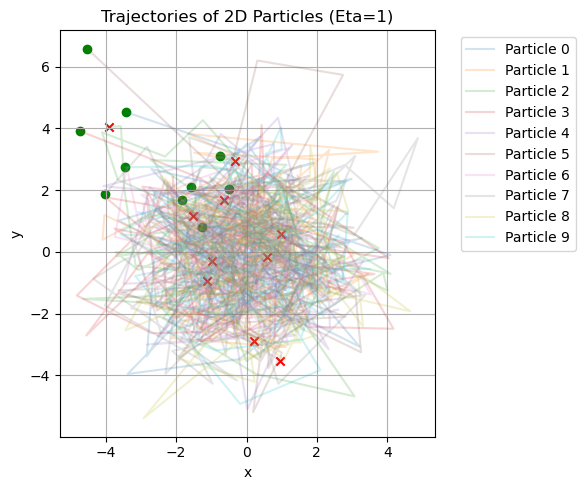

/var/folders/zl/0c18q_l567xgnm85cwp5t7xm0000gp/T/ipykernel_63922/186303026.py:23: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(samples[:, 0], samples[:, 1], alpha=0.6, edgecolors='k',marker = 'x',color = 'red', label=r'samples from $\mathcal{N}(0,2I)$')


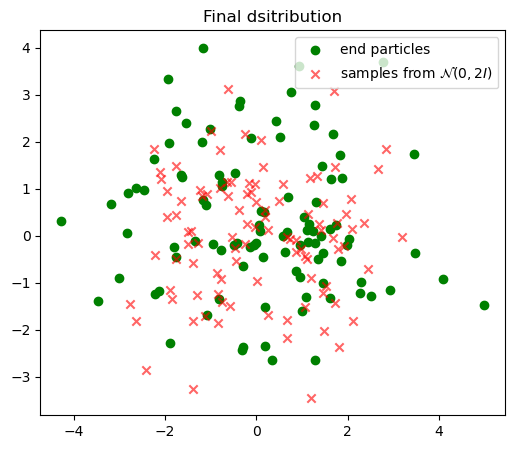

In [28]:
e,eta = 0, Eta[0]

#Trajectories 
plt.figure(figsize=(6, 5))
for p in range(min(10, n)):  # Plot only first 10 particles
    trajectory = all_particles[e, :, p]
    plt.scatter(trajectory[0, 0], trajectory[0, 1], color='green', marker='o')  # Start
    plt.scatter(trajectory[-1, 0], trajectory[-1, 1], color='red', marker='x')  # End
    plt.plot(trajectory[:, 0], trajectory[:, 1], label=f'Particle {p}',alpha =0.2)
plt.title(f'Trajectories of 2D Particles (Eta={eta})')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Final particles
plt.figure(figsize=(6, 5))
samples = np.sqrt(2) * np.random.randn(n,2)
plt.scatter(all_particles[e, :, -1, 0], all_particles[e, :, -1, 1], color='green', marker='o', label='end particles')  # End
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.6, edgecolors='k',marker = 'x',color = 'red', label=r'samples from $\mathcal{N}(0,2I)$')
plt.title("Final dsitribution")
plt.legend()
plt.show()




Sanity check : we plot $KGD_P(\hat{P}_n)$ where $\hat{P}_n$ is a discrete distribution supported on $n$ i.i.d. samples from $P = \mathcal{N}(0,2I_d)$. We plot this for increasing values of $n$.

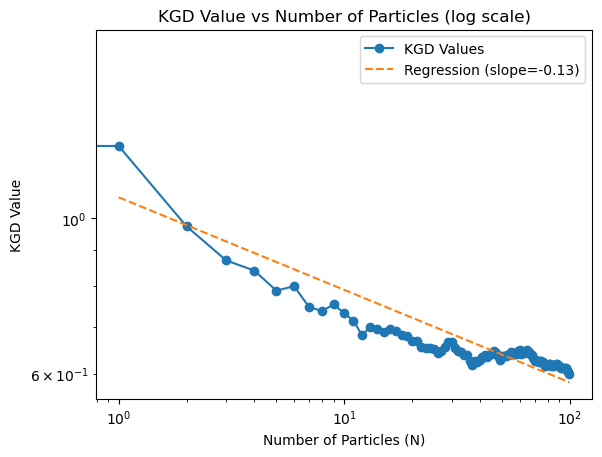

Slope of regression line: -0.13


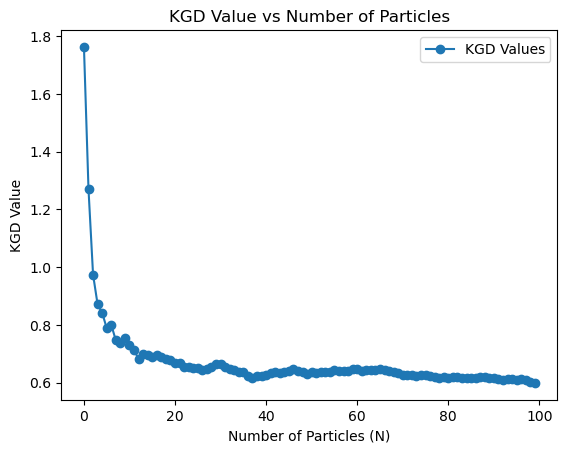

In [34]:
N_max = 100
KGD_N = KGD.cumeval(jnp.sqrt(2) * np.random.randn(N_max, 2))

# Log-log transformation
log_N = jnp.log(jnp.arange(1, N_max + 1))  # Log of particle numbers
log_KGD_N = jnp.log(KGD_N)  # Log of KGD values

# Linear regression in log-log space
A = jnp.vstack([log_N, jnp.ones_like(log_N)]).T  # Design matrix
coef, intercept = jnp.linalg.lstsq(A, log_KGD_N, rcond=None)[0]  # Solve Ax = b

# Plotting
plt.plot(KGD_N, marker='o', label='KGD Values')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Particles (N)')
plt.ylabel('KGD Value')
plt.title('KGD Value vs Number of Particles (log scale)')
plt.legend()

# Display regression line
plt.plot(jnp.exp(log_N), jnp.exp(coef * log_N + intercept), label=f'Regression (slope={coef:.2f})', linestyle='--')
plt.legend()
plt.show()

print(f"Slope of regression line: {coef:.2f}")


plt.figure()
# Plotting
plt.plot(KGD_N, marker='o', label='KGD Values')
plt.xlabel('Number of Particles (N)')
plt.ylabel('KGD Value')
plt.title('KGD Value vs Number of Particles')
plt.legend()

# 2. Linear + Quadratic term 

- $q_0(x) \propto \exp(-\|x\|^2/2)$
- $\mathcal{L}(Q)(x) = \int v(x) \ d Q(x) + \int \int w(x,x') \ d Q(x) d Q(x)$, with $v(x) = 1/2 \|x\|^2$ and $w(x,x') = x^Tx'$.

<!-- if w= 0
F(q) = L(q) + Kl(q|q0) = L(q) + int -log q0 dq +int log q dq 
L(Q) = int v(x)dq
alors F(q) = int v(x)-log q0 dQ + int log q dq = KL(q|p) où p(x) propto q0 exp(v) = exp(-||x||^2/2 + v)


P(x) propto qO(x) exp(-L'(P)(x)) -->


In [122]:
def _grad_v(X):
    return -X/2 # sanity check (en prenant v(x)= \|x\|^2/4)-> global minimizer en p Gaussienne de variance 2
def grad_w(X,Y):
    return Y 
def grad_L(X):
    return _grad_v(X) + 2/n * np.sum([grad_w(X, X) for x, y in X], axis=0)

def gradV(X):
    return grad_L(X) - s_q0(X)

In [123]:
n = 50
d = 2
Eta = [0.5,0.2,0.1]
T = 50

KGD_values = np.zeros((len(Eta), T))
all_particles = np.zeros((len(Eta), T, n, d))

for e in range(len(Eta)):
    X = np.random.randn(n, d)+ np.array([-5, 5])
    for k in range(T):
        Z = np.random.randn(n, d)
        X = X - Eta[e] * gradV(X) + np.sqrt(2*Eta[e])* Z
        KGD_values[e,k] = KGD(X,gradV)
        all_particles[e, k] = X

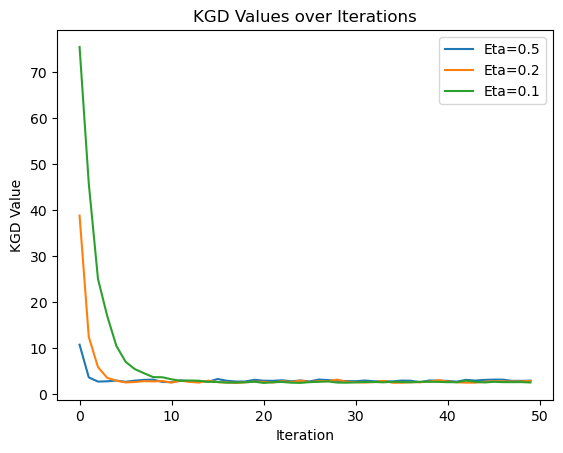

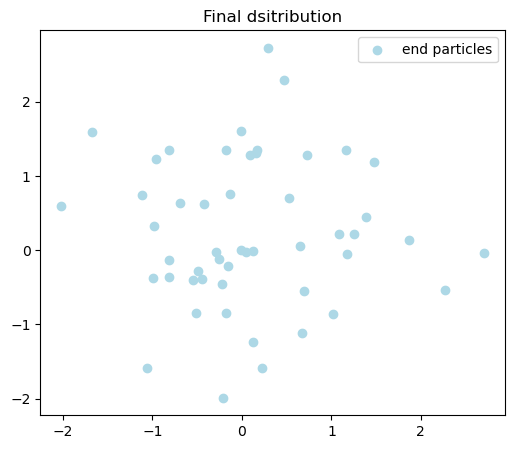

In [124]:
for e in range(len(Eta)):
    plt.plot(KGD_values[e], label=f'Eta={Eta[e]}')
plt.xlabel('Iteration')
plt.ylabel('KGD Value')
plt.title('KGD Values over Iterations')
plt.legend()


e,eta = 0, Eta[0]
# Final particles
plt.figure(figsize=(6, 5))
samples = np.sqrt(2) * np.random.randn(n,2)
plt.scatter(all_particles[e, :, -1, 0], all_particles[e, :, -1, 1], color='lightblue', marker='o', label='end particles')  # End
#plt.scatter(samples[:, 0], samples[:, 1], alpha=0.6, edgecolors='k',marker = 'x',color = 'red', label=r'samples from $\mathcal{N}(0,2I)$')
plt.title("Final dsitribution")
plt.legend()
plt.show()

# 3. MMD

### a) Q_1 is a Gaussian
- $\mathcal{L}(Q) = \frac{\gamma}{2} \textrm{MMD}(Q,Q_1)^2$
- $Q_1 = \mathcal{N}(\mu,\Sigma)$
- Gaussian kernel in the MMD: $l(x,x') = e^{\frac{\|x-x'\|^2}{2}}$

In [ ]:
mu = 10*np.ones(2)
gamma = 100
Cov = np.diag([1,1])
sigma_l = 1

l = lambda x,y : ker.k_gauss(x,y,sigma_l) #Gram matrix for gaussian kernel = shape (n,m)
dl = lambda x,y : ker.dk_gauss(x,y,sigma_l) #Gram matrix of nabla_1 k(x,y) = shape (n,m,d)

def grad_L(X):
    X1 = np.random.multivariate_normal(mu, Cov, n) # samples from Q_1
    return gamma * (-1/n * np.sum(dl(X,X1),axis = 1) + 1/n * np.sum(dl(X,X),axis = 1))

def gradV(X):
    # print(np.linalg.norm(grad_L(X)))
    # print(np.linalg.norm(s_q0(X)))
    return grad_L(X) - s_q0(X)

In [107]:
n = 100
d = 2
Eta = [0.5,0.2,0.1,0.01]
T = 100

KGD_values = np.zeros((len(Eta), T))
all_particles = np.zeros((len(Eta), T, n, d))

for e in range(len(Eta)):
    X = np.random.randn(n, d) #+ np.array([-5, 5])
    for k in range(T):
        Z = np.random.randn(n, d)
        Eps = 1 * np.random.randn(n, d)
        X = X - Eta[e] * gradV(X + Eps) + np.sqrt(2*Eta[e])* Z
        
        KGD_values[e,k] = KGD(X,gradV)
        all_particles[e, k] = X

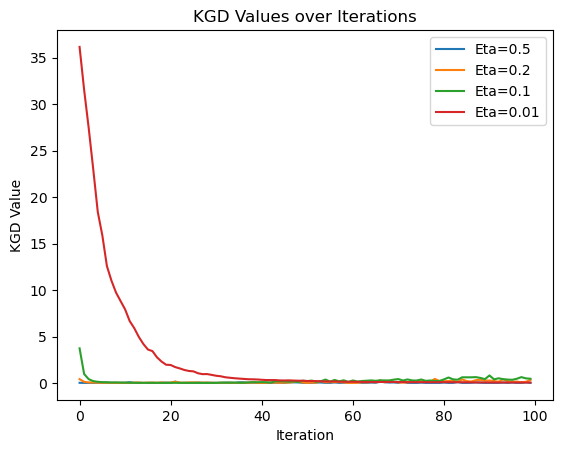

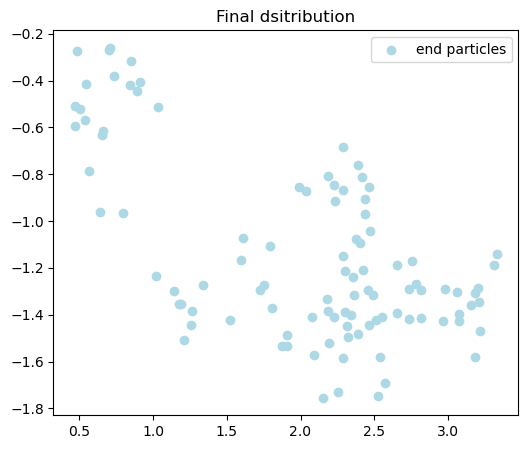

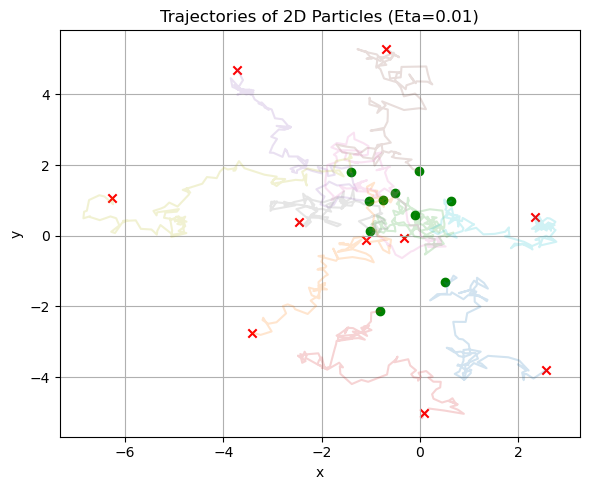

In [108]:
plt.figure()
for e in range(len(Eta)):
    plt.plot(KGD_values[e], label=f'Eta={Eta[e]}')
plt.xlabel('Iteration')
plt.ylabel('KGD Value')
plt.title('KGD Values over Iterations')
plt.legend()
plt.show()

e,eta = 3, Eta[3]
# Final particles
plt.figure(figsize=(6, 5))
samples = np.sqrt(2) * np.random.randn(n,2)
plt.scatter(all_particles[e, :, -1, 0], all_particles[e, :, -1, 1], color='lightblue', marker='o', label='end particles')  # End
#plt.scatter(samples[:, 0], samples[:, 1], alpha=0.6, edgecolors='k',marker = 'x',color = 'red', label=r'samples from $\mathcal{N}(0,2I)$')
plt.title("Final dsitribution")
plt.legend()
plt.show()

#Trajectories 
plt.figure(figsize=(6, 5))
for p in range(min(10, n)):  # Plot only first 10 particles
    trajectory = all_particles[e, :, p]
    plt.scatter(trajectory[0, 0], trajectory[0, 1], color='green', marker='o')  # Start
    plt.scatter(trajectory[-1, 0], trajectory[-1, 1], color='red', marker='x')  # End
    plt.plot(trajectory[:, 0], trajectory[:, 1], label=f'Particle {p}',alpha =0.2)
plt.title(f'Trajectories of 2D Particles (Eta={eta})')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# II/ LAPLACE KERNEL : $k(x,x') = e^{\frac{\|x-x'\|}{\sigma}}$.

# 1. MMD

In [21]:
sigma = 1
K = lambda X,Y: ker.k_laplace(X,Y,sigma) #Gram matrix for gaussian kernel = shape (n,m)
dK = lambda X,Y: ker.dk_laplace(X,Y,sigma) #Gram matrix of nabla_1 k(x,y) = shape (n,m,d)
ddK = lambda X,Y: ker.ddk_laplace(X,Y,sigma) #Gram matrix of nabla_2 . nabla_1 k(x,y) = shape (n,m)

def s_q0(X): 
    return -X
def K_PQ(X,gradV):
    return ddK(X,X) - np.sum(dK(X,X) * gradV(X)[:, np.newaxis, :], axis=2)  - (np.sum(dK(X,X) * gradV(X)[:, np.newaxis, :], axis=2)).T + K(X,X) * (gradV(X) @ gradV(X).T)
def KGD(X,gradV):
    return 1/n**2 * np.sum(K_PQ(X,gradV))

In [22]:
mu = 5*np.ones(2)
gamma = 2
sigma_l = 1

l = lambda x,y : ker.k_gauss(x,y,sigma_l) #Gram matrix for gaussian kernel = shape (n,m)
dl = lambda x,y : ker.dk_gauss(x,y,sigma_l) #Gram matrix of nabla_1 k(x,y) = shape (n,m,d)

def grad_L(X):
    X1 = np.random.multivariate_normal(mu, gamma * np.eye(d), n) # samples from Q_1
    return -1/n * np.sum(dl(X,X1),axis = 1) + 1/n * np.sum(dl(X,X),axis = 1)

def gradV(X):
    return grad_L(X) - s_q0(X)

In [23]:
n = 100
d = 2
Eta = [1,0.5,0.2,0.1]
T = 100

KGD_values = np.zeros((len(Eta), T))
all_particles = np.zeros((len(Eta), T, n, d))

for e in range(len(Eta)):
    X = np.random.randn(n, d)+ np.array([-5, 5])
    for k in range(T):
        Z = np.random.randn(n, d)
        X = X - Eta[e] * gradV(X) + np.sqrt(2*Eta[e])* Z
        
        KGD_values[e,k] = KGD(X,gradV)
        all_particles[e, k] = X

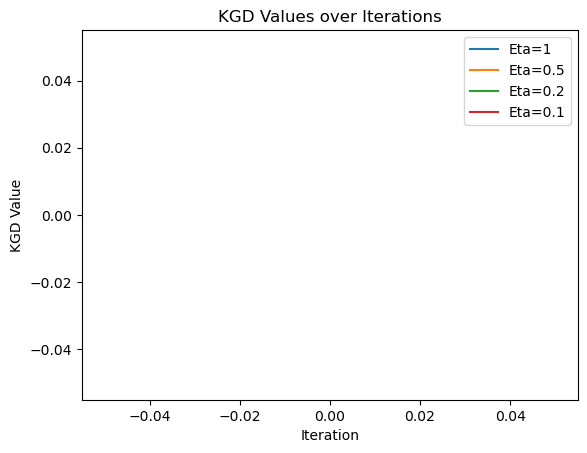

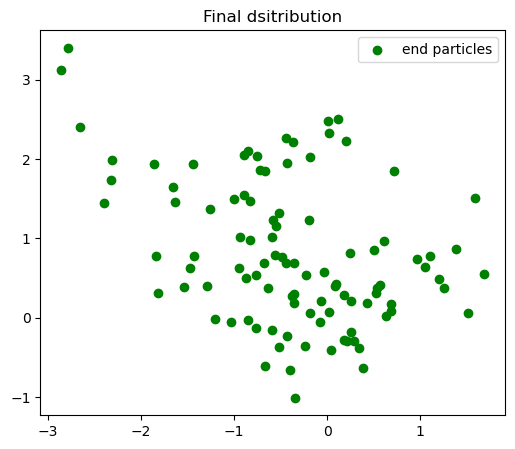

In [24]:
for e in range(len(Eta)):
    plt.plot(KGD_values[e], label=f'Eta={Eta[e]}')
plt.xlabel('Iteration')
plt.ylabel('KGD Value')
plt.title('KGD Values over Iterations')
plt.legend()


# Final particles
plt.figure(figsize=(6, 5))
samples = np.sqrt(2) * np.random.randn(n,2)
plt.scatter(all_particles[e, :, -1, 0], all_particles[e, :, -1, 1], color='green', marker='o', label='end particles')  # End
#plt.scatter(samples[:, 0], samples[:, 1], alpha=0.6, edgecolors='k',marker = 'x',color = 'red', label=r'samples from $\mathcal{N}(0,2I)$')
plt.title("Final dsitribution")
plt.legend()
plt.show()


In [19]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Parameters
# n = 50
# d = 2
# Eta = [0.1, 0.01, 0.001, 0.0001]
# iterations = n

# KGD_values = np.zeros((len(Eta), iterations))
# all_particles = np.zeros((len(Eta), iterations, n, d))

# # Dummy dynamics (replace with actual V and KGD if needed)
# def V(X):
#     return X

# def KGD(X):
#     return np.sum(X**2)

# # Simulation
# for e in range(len(Eta)):
#     X = np.random.randn(n, d) + np.array([-3, 3])
#     for k in range(iterations):
#         Z = np.random.randn(n, d)
#         X = X - Eta[e] * V(X) + np.sqrt(2 * Eta[e]) * Z
#         KGD_values[e, k] = KGD(X)
#         all_particles[e, k] = X

# # Time slices (5 evenly spaced)
# time_slices = np.linspace(0, iterations - 1, 5, dtype=int)
# colors = sns.color_palette("viridis", len(time_slices))  # color for each time slice

# # KDE overlay for each Eta
# for e, eta in enumerate(Eta):
#     plt.figure(figsize=(6, 5))
#     for idx, t in enumerate(time_slices):
#         particles = all_particles[e, t]
#         sns.kdeplot(
#             x=particles[:, 0], y=particles[:, 1],
#             fill=False, cmap=None, color=colors[idx],
#             label=f"Iteration {t + 1}", bw_adjust=0.5
#         )
#     plt.title(f'2D KDE Evolution (Eta={eta})')
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


In [12]:
np.empty(5)

array([129.16521656, 205.37034699, 281.57547741, 357.78060783,
       427.47777778])